In [2]:
!pip3 install pandas
!pip3 install pendulum
!pip3 install keras_tuner

     |████████████████████████████████| 11.7 MB 17.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 155 kB 20.2 MB/s eta 0:00:01
     |████████████████████████████████| 489 kB 34.7 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 98 kB 10.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [3]:
import tensorflow as tf

In [4]:


BASE_MODEL_INPUT_SHAPE = (600,600,3)

cifar = tf.keras.datasets.cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar


mod_with_fc_raw = tf.keras.applications.efficientnet.EfficientNetB7(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape = BASE_MODEL_INPUT_SHAPE, pooling='max', classes=1000
)

# Make the deepest conv2d layer trainable, leave everything else
# as not trainable
for layer in mod_with_fc_raw.layers:
    layer.trainable = False
# Last conv2d layer. This we want to train .
mod_with_fc_raw.layers[-6].trainable = True

# Create the final base model
# (remove the final Dense and BatchNormalization layers ...) 
efficient_net_b_7_transferable_base_model =\
    tf.keras.Model(inputs=mod_with_fc_raw.layers[0].input, 
                    outputs=mod_with_fc_raw.layers[-3].output)


170508288/170498071 [==============================] - 10s 0us/step


2022-02-15 06:37:23.912774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 06:37:23.923033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 06:37:23.923646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 06:37:23.925789: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 06:37:23.926400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

268337152/268326632 [==============================] - 12s 0us/step


In [19]:
TRAINING_SET_SIZE = 1000

y_train_ohe = tf.one_hot([i[0] for i in  y_train],10)
indexes_for_rows = tf.range(0,y_train.shape[0])
shuffled_indexes = tf.random.shuffle(indexes_for_rows)
selected_indexes = shuffled_indexes[:TRAINING_SET_SIZE]
selected_x_train = x_train[selected_indexes,:,:,:]
selected_y_train_ohe = y_train_ohe.numpy()[selected_indexes,:]

In [5]:
from residualmlp.residual_mlp import ResidualMLP

In [6]:
from inspect import getfullargspec
getfullargspec(ResidualMLP)

FullArgSpec(args=['self', 'problem_type', 'learning_rate', 'minimum_learning_rate', 'maximum_learning_rate', 'number_of_learning_rates_to_try', 'input_shape', 'bw_images', 'base_model', 'base_model_input_shape', 'base_model_hyperparameters', 'flatten_after_base_model', 'blocks', 'minimum_number_of_blocks', 'maximum_number_of_blocks', 'minimum_number_of_layers_per_block', 'maximum_number_of_layers_per_block', 'minimum_neurons_per_block_layer', 'maximum_neurons_per_block_layer', 'n_options_of_neurons_per_layer_to_try', 'minimum_neurons_per_block_layer_decay', 'maximum_neurons_per_block_layer_decay', 'residual_bypass_dense_layers', 'b_norm_or_dropout_residual_bypass_layers', 'dropout_rate_for_bypass_layers', 'minimum_dropout_rate_for_bypass_layers', 'maximim_dropout_rate_for_bypass_layers', 'n_options_dropout_rate_for_bypass_layers', 'inter_block_layers_per_block', 'minimum_inter_block_layers_per_block', 'maximum_inter_block_layers_per_block', 'n_options_inter_block_layers_per_block', 'b_

In [17]:
# [batch, timesteps, feature]

BATCH = 5
STEPS = 20
NEURONS_GRU_MLP = 50
NEURONS_EFF_MLP = 50

inp = tf.keras.layers.Input(shape=(32,32,3))
x = tf.keras.layers.Resizing(600,600)(inp)
y = inp

x = efficient_net_b_7_transferable_base_model(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(NEURONS_EFF_MLP,
                        activation=tf.keras.activations.relu, 
                        kernel_initializer=tf.keras.initializers.GlorotNormal)(x)
x_residual = x

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(NEURONS_EFF_MLP,
                        activation=tf.keras.activations.relu, 
                        kernel_initializer=tf.keras.initializers.GlorotNormal)(x)
x = tf.keras.layers.Concatenate(axis=1)([x,x_residual])

y_ch0 = y[:,:,:,0] # tf.keras.layers.Flatten()
y_ch1 = y[:,:,:,1] # tf.keras.layers.Flatten()(
y_ch2 = y[:,:,:,2] # tf.keras.layers.Flatten()()

y_ch0, y_ch0_state  = tf.keras.layers.GRU(32,input_shape=(None,32,32),return_sequences=True, return_state=True)(y_ch0)
y_ch1, y_ch1_state  = tf.keras.layers.GRU(32,input_shape=(None,32,32),return_sequences=True, return_state=True)(y_ch1)
y_ch2, y_ch2_state  = tf.keras.layers.GRU(32,input_shape=(None,32,32),return_sequences=True, return_state=True)(y_ch2)

y_ch0 = tf.keras.layers.GRU(32,input_shape=(None,32,32))([y_ch0,y_ch0_state])
y_ch1 = tf.keras.layers.GRU(32,input_shape=(None,32,32))([y_ch1,y_ch1_state])
y_ch2 = tf.keras.layers.GRU(32,input_shape=(None,32,32))([y_ch2,y_ch2_state])

y = tf.keras.layers.Concatenate(axis=1)([y_ch0,y_ch1,y_ch2])

y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Dense(NEURONS_GRU_MLP,
                        activation=tf.keras.activations.relu, 
                        kernel_initializer=tf.keras.initializers.GlorotNormal)(y)

y_residual = y

y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Dense(NEURONS_GRU_MLP,
                        activation=tf.keras.activations.relu, 
                        kernel_initializer=tf.keras.initializers.GlorotNormal)(y)
y = tf.keras.layers.Concatenate(axis=1)([y,y_residual])

final_base_model_output = tf.keras.layers.Concatenate(axis=1)([x,y])

concatenated_efficientnet_gru_model = tf.keras.Model(inputs=inp,outputs=final_base_model_output)

concatenated_efficientnet_gru_model(x_train[:10])



<tf.Tensor: shape=(10, 200), dtype=float32, numpy=
array([[0.        , 0.07617854, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.06186103, 0.        , 0.13261008, ..., 0.        , 0.06380671,
        0.        ],
       [0.        , 0.        , 0.19236365, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.02141286, 0.08560591, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00703841, 0.03448487, ..., 0.        , 0.10118318,
        0.        ],
       [0.        , 0.        , 0.07446887, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)>

In [23]:
concatenated_efficientnet_gru_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_21 (Sl (None, 32, 32)       0           input_9[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_22 (Sl (None, 32, 32)       0           input_9[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_23 (Sl (None, 32, 32)       0           input_9[0][0]                    
____________________________________________________________________________________________

In [32]:

# test base model by itself

inp_test = tf.keras.layers.Input(shape=(32,32,3))
x = concatenated_efficientnet_gru_model(inp_test)
output_test = tf.keras.layers.Dense(10,activation="softmax")(x)
test_model = tf.keras.Model(inputs=inp_test,outputs=output_test)

test_model.compile(optimizer=\
                     tf.keras.optimizers.Adam(
                         .0001, 
                         clipnorm=1.0),
                         loss=tf.keras.losses.CategoricalCrossentropy(), 
                         metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k = 1)])

In [18]:
# Train base model:

In [33]:
import os
BATCH_SIZE = 5
PATIENCE = 3
PATIENCE_MIN_DELTA = .002
RESULTS_DIR_FOR_FINAL_MODEL = "2022-02-15_efficientnet_concat_gru_model"

logdir_final_model = os.path.join("logs",
                                  RESULTS_DIR_FOR_FINAL_MODEL + "_TB")
tensorboard_callback_final =\
    tf.keras.callbacks.TensorBoard(logdir_final_model, histogram_freq=1)

history = test_model.fit(x=selected_x_train,  
                    y=selected_y_train_ohe, 
                    batch_size=BATCH_SIZE, 
                    epochs=10,      
                    verbose='auto', 
                    callbacks=[tf.keras.callbacks.\
                               EarlyStopping(monitor='val_loss',
                                             patience=PATIENCE,
                                             min_delta=PATIENCE_MIN_DELTA,
                                             restore_best_weights=True),
                            tensorboard_callback_final], 
                    validation_split=0.3,
                    validation_data=None,
                    shuffle=True,
                    class_weight=None, 
                    sample_weight=None, 
                    initial_epoch=0, 
                    steps_per_epoch=None, 
                    validation_steps=None, 
                    validation_batch_size=10, 
                    validation_freq=1, 
                    max_queue_size=10, 
                    workers=5, 
                    use_multiprocessing=True)

2022-02-15 07:09:53.259512: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-15 07:09:53.259557: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-02-15 07:09:53.701729: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-15 07:09:53.702063: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed


Epoch 1/10
  1/140 [..............................] - ETA: 46:39 - loss: 3.4724 - top_k_categorical_accuracy: 0.0000e+00

2022-02-15 07:10:15.703146: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-15 07:10:15.703206: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/140 [..............................] - ETA: 4:49 - loss: 3.0297 - top_k_categorical_accuracy: 0.1000     

2022-02-15 07:10:16.937668: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-02-15 07:10:16.938234: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed
2022-02-15 07:10:17.029178: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 5169 callback api events and 4821 activity events. 
2022-02-15 07:10:17.132387: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-15 07:10:17.304608: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/2022-02-15_efficientnet_concat_gru_model_TB/train/plugins/profile/2022_02_15_07_10_17

2022-02-15 07:10:17.373686: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/2022-02-15_efficientnet_concat_gru_model_TB/train/plugins/profile/2022_02_15_07_10_17/na45u7x1si.trace.json.gz
2022-02-15 07:10:17.512950: I tens

140/140 [==============================] - 84s 456ms/step - loss: 1.8449 - top_k_categorical_accuracy: 0.3486 - val_loss: 1.5545 - val_top_k_categorical_accuracy: 0.5967
Epoch 2/10
140/140 [==============================] - 56s 399ms/step - loss: 0.8290 - top_k_categorical_accuracy: 0.7257 - val_loss: 0.8769 - val_top_k_categorical_accuracy: 0.7467
Epoch 3/10
140/140 [==============================] - 56s 400ms/step - loss: 0.5069 - top_k_categorical_accuracy: 0.8529 - val_loss: 0.6809 - val_top_k_categorical_accuracy: 0.7767
Epoch 4/10
140/140 [==============================] - 56s 400ms/step - loss: 0.3956 - top_k_categorical_accuracy: 0.8771 - val_loss: 0.6608 - val_top_k_categorical_accuracy: 0.8033
Epoch 5/10
140/140 [==============================] - 56s 400ms/step - loss: 0.3103 - top_k_categorical_accuracy: 0.9029 - val_loss: 0.6735 - val_top_k_categorical_accuracy: 0.8067
Epoch 6/10
140/140 [==============================] - 56s 400ms/step - loss: 0.2850 - top_k_categorical_ac

In [39]:
!pip3 install matplotlib
import pandas as pd
import matplotlib.pyplot as plt
hy = pd.DataFrame(history.history)

     |████████████████████████████████| 11.3 MB 20.6 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 27.0 MB/s eta 0:00:01
     |████████████████████████████████| 895 kB 27.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 28.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [35]:
hy

,loss,top_k_categorical_accuracy,val_loss,val_top_k_categorical_accuracy
0,1.844856,0.348571,1.554503,0.596667
1,0.828951,0.725714,0.876880,0.746667
2,0.506860,0.852857,0.680901,0.776667
3,0.395619,0.877143,0.660770,0.803333
4,0.310284,0.902857,0.673487,0.806667
5,0.284952,0.911429,0.661234,0.806667
6,0.195833,0.948571,0.717285,0.800000


<AxesSubplot:>

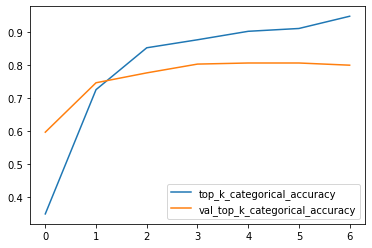

In [40]:
hy[["top_k_categorical_accuracy","val_top_k_categorical_accuracy"]].plot()

<AxesSubplot:>

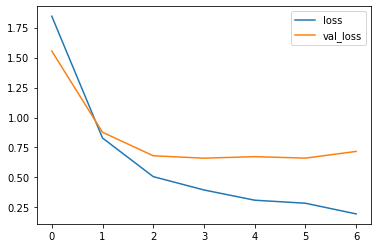

In [41]:
hy[["loss","val_loss"]].plot()